In [1]:
%load_ext autoreload
%autoreload 2
%aimport

!nvidia-smi

Modules to reload:
all-except-skipped

Modules to skip:

Sat Apr  3 00:49:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   37C    P0    37W / 300W |   1888MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                   

- https://www.kaggle.com/boliu0/landmark-recognition-2020-third-place-submission
- https://github.com/haqishen/Google-Landmark-Recognition-2020-3rd-Place-Solution
- https://www.kaggle.com/zzy990106/b0-bert-cv0-9
- https://github.com/yang-zhang/product_category/blob/dev/notebooks/transformer_20210307E1--pin_memory.

In [2]:
HOME = "/data/git/shopee-product-matching"
p_out = f'{HOME}/output/infer0002'
!mkdir -p {p_out}
p_prp = f'{HOME}/output/prep001/train_prep.csv'

FOLD = 0
p_trained = f'{HOME}/output/trn0002'

import sys
sys.path.append(f"{HOME}/src")

import pandas as pd
from pl_model import ShpModel
import os
import torch
import numpy as np
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# inference model

In [3]:
import os
import cv2
import glob
import math
import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import albumentations
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

import geffnet

class ArcMarginProduct_subcenter(nn.Module):
    def __init__(self, in_features, out_features, k=3):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features*k, in_features))
        self.reset_parameters()
        self.k = k
        self.out_features = out_features
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        
    def forward(self, features):
        cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
        cosine_all = cosine_all.view(-1, self.out_features, self.k)
        cosine, _ = torch.max(cosine_all, dim=2)
        return cosine 

sigmoid = torch.nn.Sigmoid()
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class Swish_module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)

    
 
    
class enet_arcface_FINAL(nn.Module):

    def __init__(self, enet_type, out_dim):
        super(enet_arcface_FINAL, self).__init__()
        self.enet = geffnet.create_model(enet_type.replace('-', '_'), pretrained=None)
        self.feat = nn.Linear(self.enet.classifier.in_features, 512)
        self.swish = Swish_module()
        self.metric_classify = ArcMarginProduct_subcenter(512, out_dim)
        self.enet.classifier = nn.Identity()
 
    def forward(self, x):
        x = self.enet(x)
        x = self.swish(self.feat(x))
        return F.normalize(x), self.metric_classify(x)
    
    
from rexnetv1 import ReXNetV1
from resnest.torch import resnest101    
class rex20_arcface(nn.Module):

    def __init__(self, enet_type, out_dim, load_pretrained=False):
        super(rex20_arcface, self).__init__()
        self.enet = ReXNetV1(width_mult=2.0)
        if load_pretrained:
            pretrain_wts = "/workspace/rexnetv1_2.0x.pth"            
            sd = torch.load(pretrain_wts)
            self.enet.load_state_dict(sd, strict=True)        
        
        self.feat = nn.Linear(self.enet.output[1].in_channels, 512)
        self.swish = Swish_module()
        self.metric_classify = ArcMarginProduct_subcenter(512, out_dim)
        self.enet.output = nn.Identity()
    
    def forward(self, x):
        x = self.enet(x)
        if x.ndim==1: 
            x = x.unsqueeze(0)          
        x = self.swish(self.feat(x))
        return F.normalize(x), self.metric_classify(x)    
    
class nest101_arcface(nn.Module):

    def __init__(self, enet_type, out_dim):
        super(nest101_arcface, self).__init__()
        self.enet = resnest101(pretrained=False)
        self.feat = nn.Linear(self.enet.fc.in_features, 512)
        self.swish = Swish_module()
        self.metric_classify = ArcMarginProduct_subcenter(512, out_dim)
        self.enet.fc = nn.Identity()    
    def forward(self, x):
        x = self.enet(x)
        x = self.swish(self.feat(x))
        return F.normalize(x), self.metric_classify(x)    

# def load_model(model, model_file):
#     state_dict = torch.load(model_file)
#     if "model_state_dict" in state_dict.keys():
#         state_dict = state_dict["model_state_dict"]
#     state_dict = {k[7:] if k.startswith('module.') else k: state_dict[k] for k in state_dict.keys()}
# #     del state_dict['metric_classify.weight']
#     model.load_state_dict(state_dict, strict=True)
#     print(f"loaded {model_file}")
#     model.eval()    
#     return model

def load_model(model, plmodel):
    state_dict = plmodel.state_dict()
    if "model_state_dict" in state_dict.keys():
        state_dict = state_dict["model_state_dict"]
    state_dict = {k[6:] if k.startswith('model.') else k: state_dict[k] for k in state_dict.keys()}
#     del state_dict['metric_classify.weight']
    model.load_state_dict(state_dict, strict=True)
    model.eval()    
    return model

# load model

In [4]:
ls -hl {p_trained}/tensorboard_csv/*/checkpoints/*.ckpt

-rw-rw-r-- 1 ubuntu ubuntu 326M Apr  2 17:41 '/data/git/shopee-product-matching/output/trn0002/tensorboard_csv/2_2/checkpoints/epoch=17-step=30833.ckpt'


In [5]:
ckpt = f'{p_trained}/tensorboard_csv/2_2/checkpoints/epoch=17-step=30833.ckpt'
shpmodel = ShpModel.load_from_checkpoint(ckpt)
out_dim = shpmodel.num_classes

In [6]:
device = torch.device('cuda')


In [7]:
model_b0 = enet_arcface_FINAL('tf_efficientnet_b3_ns', out_dim=out_dim).to(device)
model_b0 = load_model(model_b0, shpmodel)
model_b0.to(device)
model = model_b0

# dataloader

In [8]:
from dataset import ShopeeDataset, get_transforms
from torch.utils.data import DataLoader

df = pd.read_csv(p_prp)

pids = df.posting_id.values

tfms_trn, tfms_val = get_transforms(224)
ds = ShopeeDataset(df, mode="test", transform=tfms_val)
dl = DataLoader(ds,
            batch_size=128,
            num_workers=8,
            pin_memory=True,
        )

# get feats

In [9]:
for dat in dl:
    dat = dat.to(device)
    with torch.no_grad():
        feat,_ = model(dat)
    break

feat.shape

torch.Size([128, 512])

In [10]:
feats = np.zeros((len(ds), feat.shape[1]))
i = 0
for dat in tqdm(dl):
    with torch.no_grad():
        dat = dat.to(device)
        feat,_ = model(dat)
        l = len(feat)
        feats[i : i + l, :] = feat.cpu().detach().numpy()
        i += l

  0%|          | 0/268 [00:00<?, ?it/s]

In [11]:
feats.shape

(34250, 512)

# verify

In [12]:
import torch
import numpy as np
from tqdm import tqdm

from utils import meanf1, get_targets, get_preds_by_thrsh, preds2pids
from neighbor import get_nbrs

In [13]:
targets = get_targets(df)

In [14]:
dists, idx = get_nbrs(feats)

chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [24]:
preds = get_preds_by_thrsh(dists, idx, thrsh=.5)
preds = preds2pids(preds, pids)

In [25]:
meanf1(preds,targets)

0.6302684777836477

In [31]:
thrshes = np.linspace(0.2,0.6,num=11)
print(thrshes)

[0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52 0.56 0.6 ]


In [32]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, idx, thrsh)
    preds = preds2pids(preds, pids)
    f1_lst.append(meanf1(preds,targets))

100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


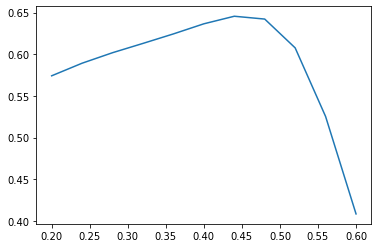

In [33]:
import matplotlib.pyplot as plt
plt.plot(thrshes, f1_lst)  

In [34]:
def find_best(dists, idx, thrshes = np.linspace(1.75,2.25,num=11)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    return f1_best, thrsh_best, preds_best

In [35]:
f1_best, thrsh_best, preds_best = find_best(dists, idx, thrshes)

100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


In [36]:
f1_best, thrsh_best

(0.6456769840176465, 0.43999999999999995)

In [23]:
ckpt

'/data/git/shopee-product-matching/output/trn0002/tensorboard_csv/2_2/checkpoints/epoch=17-step=30833.ckpt'

In [30]:
!cp {ckpt} ../output/